In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import math as math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom


In [3]:
import random
train=[]
w = [0.4,0.3,0.3]
out = []
for i in range(10000):
    x_out=[]
    x = random.random()
    x1 = normpdf(x,0,4)
    x2 = normpdf(x,-6,4)
    x3 = normpdf(x,6,4)
    x_out.append(x1)
    x_out.append(x2)
    x_out.append(x3)
    x_out = np.asarray(x_out)
    out.append(0.4*x1 + 0.3*x2 + 0.3*x3)
    train.append(x_out)
    
train = np.asarray(train,np.float64)
out = np.asarray(out,np.float64)
out = torch.from_numpy(out)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc3 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc3(x)

        return out


In [5]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        
        # final fully-connected layer
        self.fc3 = nn.Linear(hidden_dim*2, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc3(x))

        return out

In [6]:
# Discriminator hyperparams

# Size of input image to discriminator 
input_size = 3
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 8

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 10
# Size of discriminator output (generated image)
g_output_size = 3
# Size of first hidden layer in the generator
g_hidden_size = 8

In [7]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=3, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=10, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [8]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [9]:
import pickle as pkl

# training hyperparams
num_epochs = 20
batch_size=256
# keep track of loss and generated, "fake" samples
samples = []
lossesd = []
lossesg=[]

criterion = nn.BCEWithLogitsLoss()
# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
epochs=[]
for epoch in range(num_epochs):
    j=0
    for t in train:
                
                
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        t = torch.from_numpy(t).float()
        D_real = D(t)
        output = torch.tensor([out[j]])

        d_real_loss = criterion(D_real, output)
        
        # 2. Train with fake images
        
        # Generate fake examples
        z = np.random.uniform(-1, 1, size=10)
        z = torch.from_numpy(z).float()
        fake_t = G(z)
        
        # Compute the discriminator losses on fake data       
        D_fake = D(fake_t)
        output = torch.tensor([out[j]])
        
        d_fake_loss = criterion(D_fake,output)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=10)
        z = torch.from_numpy(z).float()
        fake_t = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_t)
        output = torch.tensor([out[j]])

        g_loss = criterion(D_fake,output) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
        
        if j == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
            
            
        j+=1

    epochs.append(epoch)
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    lossesd.append(d_loss.item())
    lossesg.append(g_loss.item())
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode

    
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

c:\users\tushar\anaconda3\envs\conda_pip_env\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   20] | d_loss: 1.5119 | g_loss: 0.7462
Epoch [    2/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [    3/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [    4/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [    5/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [    6/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [    7/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [    8/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [    9/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [   10/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [   11/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [   12/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [   13/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [   14/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [   15/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [   16/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [   17/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [   18/   20] | d_loss: 0.4489 | g_loss: 0.2244
Epoch [   19/   20] | d_loss

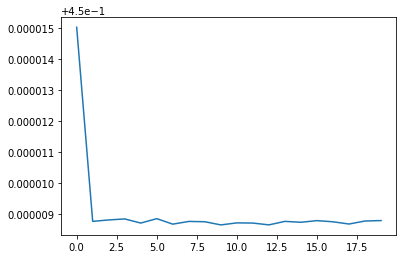

In [10]:

import matplotlib.pyplot as plt
plt.plot(epochs,lossesd)

In [59]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

list_sam = []
for i in range(20):
    for j in range(16):
        listing=[]
        for k in range(3):
            item = samples[i][j][k].detach().numpy()
            listing.append(item)
            
        list_sam.append(listing)

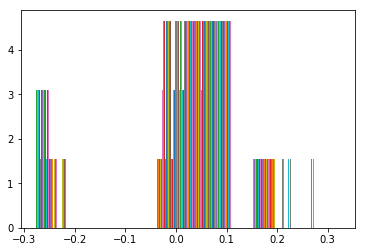

In [60]:
plt.hist(list_sam, bins=3, density=True)
plt.show()

In [61]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=3, init_params='random')
model.fit(list_sam)



GaussianMixture(covariance_type='full', init_params='random', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [62]:
yhat1 = model.predict(list_sam)

# check latent value for first few points
print(yhat1[:100])
# check latent value for last few points
print(yhat1[-100:])

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 1 1 1 2 2 2 1 2 1 2 1 2 1 2 1 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [63]:
model = GaussianMixture(n_components=3, init_params='random')
model.fit(train)

GaussianMixture(covariance_type='full', init_params='random', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [64]:
yhat2 = model.predict(train)

# check latent value for first few points
print(yhat2[:100])
# check latent value for last few points
print(yhat2[-100:])

[0 0 0 0 0 2 0 0 0 2 2 2 2 0 2 2 0 0 2 0 2 2 2 0 0 0 2 2 0 0 0 2 0 2 0 0 0
 0 0 0 0 0 0 2 2 2 2 0 2 2 0 2 2 0 0 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 2 2 0 0
 0 0 2 0 2 2 0 2 2 0 2 2 0 0 0 0 0 2 2 2 0 0 0 0 2 2]
[2 0 0 2 2 2 0 0 0 0 2 0 0 2 0 2 2 2 0 0 0 2 0 2 0 0 2 0 0 0 2 0 0 0 0 0 2
 2 0 0 0 2 2 2 2 0 0 0 2 2 0 0 0 0 0 2 2 0 2 2 2 0 0 2 2 0 0 2 2 0 0 2 2 2
 2 2 2 0 2 2 2 2 0 2 2 2 2 0 2 0 0 0 2 0 2 2 2 0 2 2]


In [65]:
import math
def kl_divergence(p, q):
    a=0
    for i in range(len(p)):
        if(q[i]!=0):
            if((p[i]/q[i])>0):
                a+=sum(p[i] * math.log2(p[i]/q[i]))          
    return a

In [66]:
loss=0
yhat1 = torch.from_numpy(yhat1)
yhat2 = torch.from_numpy(yhat2)

sum1 = sum(yhat1)
for i in range(len(yhat1)):
    yhat1[i] = yhat1[i]/sum1
sum2 = sum(yhat2)
for i in range(len(yhat2)):
    yhat2[i] = yhat2[i]/sum1    


kl_pq = kl_divergence(yhat1, yhat2)
print('KL(P || Q): %.3f bits' % kl_pq)



    

KL(P || Q): 0.000 bits
